## Imports

In [1]:
# import numpy as np
from numpy import *

from scipy import optimize
from scipy.integrate import solve_ivp, cumtrapz
from scipy.linalg import null_space, expm, inv, norm, eig

from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.animation import FuncAnimation

from types import SimpleNamespace

import inspect

### Geometry variables

In [2]:
# Todo: Define rho then get n_cables and n_dims from rho matrix
n_cables = 4
n_dims = 3

# TODO: Different cable lengths for different cables
cable_length = 1.23

# Array of cable lengths
lq = cable_length * ones(n_cables).reshape(-1,1,1)

# Load - Rigid body dimensions
length = .05
width = .05
height = .05

# Matrix of attachment points in body frame
# Change also --> q0, Ai

# Quadrotor enumetation starts at N and goes clockwise (E,S,W)
rho = array([ [[ length/2], [ width/2], [-height/2]],
              [[-length/2], [ width/2], [-height/2]],
              [[-length/2], [-width/2], [-height/2]],
              [[ length/2], [-width/2], [-height/2]] ])


## Control gains and simulation parameters

In [3]:
# Integration times

t0 = 0
tf = 10

# DEBUG selectors

# For a complete Lyapunov function with negative semi-definite time derivative 
NO_U_PERP_CROSS_TERMS = False

# TLd derivatives are zero (emulate solution of optimization problem)
TLD_DERIVATIVES_ZERO = False

### Control gains

In [4]:
L_q = 50
L_oq = 10

L_qR = 100
L_oqR = 10

kp = 1.0
kv = 1.0

x_pv = (kp + kv) / 2

kq = 20
koq = 5

kqR = 100
kqo = 10

# DEBUG
TL_repulsive_gain = 0.0
TL_damping = 0.0

mL = 1.000
mass_quad = 1.500
mQ = mass_quad * ones([n_cables,1,1])

g = 9.8

# inertia matrix for the quadrotors
J = diag([0.21, 0.22, 0.23])
inv_J = inv(J)

J = stack(n_cables*[J])
inv_J = stack(n_cables*[inv_J])

e1 = array([[1,0,0]]).T
e2 = array([[0,1,0]]).T
e3 = array([[0,0,1]]).T

# Minimum angle with vertical of z-body direction when optimizing
theta_min_for_optimization = deg2rad(20)

## Load trajectory

In [5]:
import sympy as sp
from sympy.utilities.autowrap import autowrap
from sympy.utilities.autowrap import ufuncify

t = sp.symbols('t', real=True)

r,rx,ry = sp.symbols('r r_x r_y')
omega,omega_x,omega_y = sp.symbols('omega omega_x omega_y')
theta_x,theta_y = sp.symbols('theta_x theta_y')
alpha = sp.symbols('alpha')

### Trajectory parameters

# # Circle
# args = {rx:10,
#        ry:10,
#        omega_x: 1,
#        omega_y: 1,
#        theta_x: sp.pi/2,
#        theta_y: 0}

# # Oval
# args = {rx:10,
#        ry:15,
#        omega_x: 1,
#        omega_y: sp.S(1)/2,
#        theta_x: sp.pi/2,
#        theta_y: 0}

# Lemniscate
args = {rx:10,
       ry:15,
       omega_x: 1,
       omega_y: sp.S(1)/2,
       theta_x: 0,
       theta_y: 0}

# Lemniscate
args = {rx:1,
       ry:2,
       omega_x: sp.S(1)/2,
       omega_y: (sp.S(1)/2)/2,
       theta_x: 0,
       theta_y: 0,  
       theta_x: sp.pi/4,
       theta_y: sp.pi/4,  
#        omega_x: 1e-3,
#        omega_y: 1e-3,
#        theta_x: sp.pi/2+1e-3,
#        theta_y: sp.pi/2+1e-3,
       }


# Trajectory definition

p_symb = sp.Matrix([rx*sp.sin(omega_x*t+theta_x),
                    ry*sp.sin(omega_y*t+theta_y),
                     -0.25 + 0*t])

In [6]:
p_vec = stack([ufuncify(t,p_symb[i].subs(args)) for i in arange(n_dims)])
v_vec = stack([ufuncify(t,p_symb.diff(t)[i].subs(args)) for i in arange(n_dims)])
a_vec = stack([ufuncify(t,p_symb.diff(t,2)[i].subs(args)) for i in arange(n_dims)])
da_vec = stack([ufuncify(t,p_symb.diff(t,3)[i].subs(args)) for i in arange(n_dims)])
d2a_vec = stack([ufuncify(t,p_symb.diff(t,4)[i].subs(args)) for i in arange(n_dims)])

def pr(x_orig):
    x = asarray(x_orig).reshape(-1,1)
    
    vec = stack([p_vec[i](x) for i in range(len(p_vec))],axis=1).reshape(-1,1,3,1)

    # If first dimension is singleton then remove it
    if(vec.shape[0]==1):
        vec = vec.reshape(vec.shape[2:])
    
    return vec

def dpr(x_orig):
    x = asarray(x_orig).reshape(-1,1)
    
    vec = stack([v_vec[i](x) for i in range(len(v_vec))],axis=1).reshape(-1,1,3,1)

    # If first dimension is singleton then remove it
    if(vec.shape[0]==1):
        vec = vec.reshape(vec.shape[2:])
    
    return vec

def d2pr(x_orig):
    x = asarray(x_orig).reshape(-1,1)
    
    vec = stack([a_vec[i](x) for i in range(len(a_vec))],axis=1).reshape(-1,1,3,1)

    # If first dimension is singleton then remove it
    if(vec.shape[0]==1):
        vec = vec.reshape(vec.shape[2:])
    
    return vec

def d3pr(x_orig):
    x = asarray(x_orig).reshape(-1,1)
    
    vec = stack([da_vec[i](x) for i in range(len(a_vec))],axis=1).reshape(-1,1,3,1)

    # If first dimension is singleton then remove it
    if(vec.shape[0]==1):
        vec = vec.reshape(vec.shape[2:])
    
    return vec

def d4pr(x_orig):
    x = asarray(x_orig).reshape(-1,1)
    
    vec = stack([d2a_vec[i](x) for i in range(len(a_vec))],axis=1).reshape(-1,1,3,1)

    # If first dimension is singleton then remove it
    if(vec.shape[0]==1):
        vec = vec.reshape(vec.shape[2:])
    
    return vec

### Auxiliar functions

In [7]:
def skew(v):
    # New shape is v shape with last dimension 3 instead of 1 (3x1 vector --> 3x3 matrix)
    s = asarray(v.shape)
    s[-1] = 3
    
    # Vectorize
    # Maintains the shape of v for vi
    v0 = v[...,0,0,newaxis,newaxis]
    v1 = v[...,1,0,newaxis,newaxis]
    v2 = v[...,2,0,newaxis,newaxis]

    z = zeros_like(v0)
    
    # TODO: Check that dim(v) = 3
    res = concatenate([z, -v2, v1,
                    v2, z, -v0,
                    -v1, v0, z],axis=-2)
    
    return res.reshape(s)

def unskew(M):
    # New shape is M shape with last dimension 1 instead of 3 (3x3 matrix --> 3x1 vector)
    s = asarray(M.shape)
    s[-1] = 1

    # TODO: Check if M is anti-symmetric
#     TODO: stack along axis=-1 instead of using reshape()
    
    res = stack([-M[...,1,2].reshape(-1,1),
                  M[...,0,2].reshape(-1,1),
                  -M[...,0,1].reshape(-1,1)],axis=1).reshape(s)
    
    return res

# TODO: Check that unskew(skew(v)) == v
# TODO: Do not make assumptions on shape of input

In [8]:
def mt(M):
# Matrix transpose no matter what is M shape.  M = (...) x n x m or M = (...) x m x n
    
    return np.swapaxes(M,-1,-2)

In [9]:
# TODO: Vectorize

# Numpy rotation matrices around x,y,z axis

def Rx(theta):
    return array([[1, 0, 0],
                   [ 0, cos(theta), -sin(theta)],
                   [0, sin(theta), cos(theta)]])

def Ry(theta):
    return array([[cos(theta), 0, -sin(theta)],
                   [0., 1, 0],
                  [sin(theta), 0, cos(theta)]])
                   

def Rz(theta):
    return array([[cos(theta), -sin(theta), 0],
                   [sin(theta), cos(theta), 0],
                   [0,0, 1]])

In [10]:
# TODO: vectorize

# From: https://www.learnopencv.com/rotation-matrix-to-euler-angles/
# Calculates Rotation Matrix given euler angles.
# theta :: [roll pitch yaw]
def eulerAnglesToRotationMatrix(theta):

    R_x = np.array([[1,          0,                 0                ],
                    [0,         np.cos(theta[0]),  -np.sin(theta[0]) ],
                    [0,         np.sin(theta[0]),   np.cos(theta[0]) ]])

    R_y = np.array([[ np.cos(theta[1]),   0,      np.sin(theta[1])  ],
                    [ 0,                  1,      0                 ],
                    [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]])

    R_z = np.array([[np.cos(theta[2]),   -np.sin(theta[2]),    0],
                    [np.sin(theta[2]),    np.cos(theta[2]),    0],
                    [0,                   0,                   1]])

    R = R_z @ R_y @ R_x

    return R

# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
#     return True
#     return amax(abs((np.eye(3) - mt(R)@R))) < 1e-4
    return amax(abs((np.eye(3) - mt(R)@R))) < 1e-6

# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :

    assert(isRotationMatrix(R))

    sy = np.sqrt(R[...,0,0] * R[...,0,0] +  R[...,1,0] * R[...,1,0])

    singular = sy < 1e-6

    x = array(np.arctan2(R[...,2,1] , R[...,2,2]))
    y = array(np.arctan2(-R[...,2,0], sy))
    z = array(np.arctan2(R[...,1,0], R[...,0,0]))
    
    
    x[singular] = np.arctan2(-R[singular,1,2], R[singular,1,1])
    y[singular] = np.arctan2(-R[singular,2,0], sy[singular])
    z[singular] = 0

    return np.array([x, y, z])


In [11]:
def check_derivative(f,df,t,tol=1e-6):
    int_df = cumtrapz(df,t,axis=0,initial=0)
    max_error = amax(abs(f-int_df - (f[0]-int_df[0])))
    if(max_error > tol):
        caller = inspect.getframeinfo(inspect.stack()[1][0])
        print(f"High derivative error: tol < {max_error:.2E} \t Line {caller.lineno:3}: {caller.code_context}")
    return

def check_equality(arg1,arg2,tol=1e-6):
    max_error = amax(abs(arg1-arg2))
    if(max_error > tol):
        caller = inspect.getframeinfo(inspect.stack()[1][0])
        print(f"High state error: tol < {max_error:.2E} \t Line {caller.lineno:3}: {caller.code_context}")
    return

## Problem definition

### Contruction of P matrix and its nullspace

In [12]:
def matrix_nullspace(R=eye(3)):
    # Computes P matrix and its nullspace basis G for a certain load attitude
    
    # TLd = [TLd_11, TLd_12, .... , TLd_nn-1 , TLd_nn]

    # Sum of cable tensions in each axis
    P = kron( ones(n_cables), eye(n_dims))

#     P = vstack([
#         P,
#         hstack([skew(R @ rho[i]) for i in range(n_cables)])   # Only care about load yaw control (not pitch or roll)
#     ])

    # G is subspace of allowable TLd derivatives (which do not affect F or M)
    G = null_space(P)

    return (P, G)

### Load PD control functions

In [13]:
# From https://github.com/gabrii/Smoothsteps/blob/master/functions/7.txt

left_edge = 0.2
right_edge = 0.75
    
def smooth(x, left_edge=left_edge, right_edge=right_edge):
    x = (x - left_edge) / (right_edge - left_edge)
    return  -20*x**7 + 70*x**6 - 84*x**5 + 35*x**4

def Dsmooth(x, left_edge=left_edge, right_edge=right_edge):
    x = (x - left_edge) / (right_edge - left_edge)
    slope = 1 / (right_edge - left_edge)
    return  slope*(-20*7*x**6 + 70*6*x**5 - 84*5*x**4 + 35*4*x**3)

def log_barrier(x):
    x = abs(x)
    x = clip(x,left_edge,right_edge)
    x = smooth(x,left_edge,right_edge)
    x = maximum(1e-3,x)
    return -log(x)

def Dlog_barrier(x):
    x_orig = x
    s = sign(x)
    x = abs(x)
    Dx = Dsmooth(x,left_edge,right_edge)
    x = clip(x,left_edge,right_edge)
    x = smooth(x,left_edge,right_edge)
    x = maximum(1e-3,x)
    der = -s*Dx/x * (abs(x_orig) > left_edge) * (abs(x_orig) < right_edge)
    return der

In [14]:
def F_feedback(state):
#     import inspect
#     frame = inspect.currentframe()
#     print("state.p @ F_feedback(): ", hex(id(state.p)))
#     try:
#         for key,val in state.__dict__.items(): 
#             frame.f_back.f_locals[key]=val
#     finally:
#         del frame
    
#     print("p @ F_feedback():", hex(id(p)))

    p = state.p
    v = state.v
    pd = state.pd
    dpd = state.dpd
    d2pd = state.d2pd
    
    # PD controller
    F = mL * (- kp*(p-pd) 
             - kv*(v-dpd) 
             - g*e3 
             + d2pd)
    
    try:
        dv = state.dv
        d3pd = state.d3pd
        
        dF = mL * (- kp*(v-dpd) 
                 - kv*(dv-d2pd) 
                 + d3pd)
    except Exception as e: 
#         print(e)
        return F
    
    try:
        d2v = state.d2v
        d4pd = state.d4pd
        
        d2F = mL * (- kp*(dv-d2pd) 
                 - kv*(d2v-d3pd) 
                 + d4pd)
    except Exception as e: 
#         print(e)
        return (F,dF)
    
    return (F,dF,d2F)





# Cable repulsive function
def TL_repulsive(TL):
    
    cable_matrix = (- TL / norm(TL, axis=-2, keepdims=True)) * lq
    
    quad_positions = - cable_matrix + rho

    dTL = - TL_repulsive_gain * Dlog_barrier(quad_positions)
        
    dTL[:,2,0] = 0    # No repulsion along z-axis

    # TODO: Raise error
    if(isnan(dTL).any()):
        print('quad_positions:')
        print(quad_positions)
        print('Dlog_barrier:')
        print(dTL)
    
    return dTL



def cable_tensions(state):
    TLd_min = state.TLd_min
    delta_TLd = state.delta_TLd
 
    # TODO: Compute correct derivatives!
    
    TLd = TLd_min + delta_TLd
    
    try:
        dTLd_min = state.dTLd_min
        ddelta_TLd = state.ddelta_TLd
        
        dTLd = dTLd_min + ddelta_TLd
        if (TLD_DERIVATIVES_ZERO):
            dTLd = 0*dTLd;
    except Exception as e: 
#         print(e)
        return TLd

    try:
        d2TLd_min = state.d2TLd_min
        d2delta_TLd = state.d2delta_TLd
    
        d2TLd = d2TLd_min + d2delta_TLd
        if (TLD_DERIVATIVES_ZERO):
            d2TLd = 0*d2TLd;
    except Exception as e: 
#         print(e)
        return(TLd,dTLd)

    return (TLd,dTLd,d2TLd)


def q_desired_direction(state):

    I_TLd = state.I_TLd
    
    qd = - I_TLd * (mt(I_TLd) @ I_TLd) **-0.5
    
    try:
        dI_TLd = state.dI_TLd
        dqd = (- dI_TLd * (mt(I_TLd) @ I_TLd) **-0.5
                + I_TLd * (mt(I_TLd) @ dI_TLd) * (mt(I_TLd) @ I_TLd)**-1.5)
        oqd = skew(qd) @ dqd
    except Exception as e: 
#         print(e)
        return (qd)

    try:
        d2I_TLd = state.d2I_TLd
        d2qd = (
            - d2I_TLd * (mt(I_TLd) @ I_TLd)**-0.5
            - dI_TLd * -0.5 * 2 * (mt(I_TLd) @ dI_TLd) * (mt(I_TLd) @ I_TLd)**-1.5
            + dI_TLd * (mt(I_TLd) @ dI_TLd) * (mt(I_TLd) @ I_TLd)**-1.5
            + I_TLd * (mt(dI_TLd) @ dI_TLd + mt(I_TLd) @ d2I_TLd) * (mt(I_TLd) @ I_TLd)**-1.5
            + I_TLd * (mt(I_TLd) @ dI_TLd) * -1.5 * 2 * (mt(I_TLd) @ dI_TLd) * (mt(I_TLd) @ I_TLd)**-2.5
        )
        doqd = skew(qd) @ d2qd
    except Exception as e: 
#         print(e)
        return (qd, dqd, oqd)

    
    return (qd, dqd, oqd, d2qd, doqd)



def q_feedback(q,oq,qd,oqd,doqd):
    
    dq = skew(oq) @ q
    
    e_q = cross(qd,q,axis=-2)
    e_oq = oq + skew(q) @ skew(q) @ oqd
    
    inner_q_oqd = sum(q*oqd, axis=-2, keepdims=True)
    
    q_actuation = ( - kq*e_q - koq*e_oq - inner_q_oqd*dq - skew(q) @ skew(q) @ doqd)    
    
    return (q_actuation, e_q, e_oq)



def qR_desired(t,Fd):

    # Fd = - T r3
    
    r3 = -Fd
    r2 = cross(r3,e1,axis=-2)
    r1 = cross(r2,r3,axis=-2)
    
    qRd = concatenate([r1,r2,r3],axis=-1)
    qRd = qRd / norm(qRd, axis=-2, keepdims=True)
    
    
    qod = 0 * Fd
    qtaud = 0 * Fd

    return (qRd,qod,qtaud)


# def ui_perp_feedback(q,qd,oq,oqd,Doqd,a):
#     # T. Lee paper - PD controller in S(2)

#     e_q = cross(qd,q,axis=-2)
#     e_oq = oq + skew(q) @ skew(q) @ oqd
    
#     dq = skew(oq) @ q
    
#     dot_q_oqd = sum(q*oqd, axis=1, keepdims=True)

#     q_feedback = ( - kq*e_q - koq*e_oq - dot_q_oqd*dq - skew(q)@skew(q) @ Doqd)
           
#     ui_perp = mq * lq * skew(q) @ q_feedback - mq * skew(q)@skew(q) @ a 
    
#     return ui_perp



def tau_feedback(R,o,Rd,od,taud):
#     # Mellinger paper - PD controller in SO(3)
    Rd = Rd.reshape(shape(R))
    od = od.reshape(shape(o))
    taud = taud.reshape(shape(o))
    
    # Mellinger paper - PD controller in SO(3)
    e_R = 1/2 * unskew(mt(Rd) @ R - mt(R) @ Rd)
    e_o = (o - od)
     
    M = J @ ( - kqR*e_R - kqo*e_o + taud) + skew(o)@J@o

    return M



# def T_feedback(x):
# #     # Mellinger paper - PD controller in SO(3)
# #     e_R = 1/2 * unskew(Rd.T @ R - R.T @ Rd).reshape(-1,1)
# #     e_o = (o - od)
    
# #     M = I @ ( - kr*e_R - ko*e_o + taud)

#     return T


def process_state(t,y):
    
    state = SimpleNamespace()
    
    state.t = t
    
    (p,v,R,o,delta_TLd,q,oq,qR,qo,V) = unpack_solution(y)
    
    state.p = p
    state.v = v
    state.delta_TLd = delta_TLd
    state.q = q
    state.oq = oq
    state.qR = qR
    state.qo = qo
    state.V = V
    
    state.pd = pr(t).reshape(shape(p))
    state.dpd = dpr(t).reshape(shape(p))
    state.d2pd = d2pr(t).reshape(shape(p))
    state.d3pd = d3pr(t).reshape(shape(p))
    state.d4pd = d4pr(t).reshape(shape(p))
#     state.d5pd = d5pr(t).reshape(shape(p))
        
    # Load R(3) controller
  
    Fd = F_feedback(state)    
    
    state.Fd = Fd
    
    # Retrieve TLd - Cable tensions
    
    (P, G) = matrix_nullspace()
    
    # Minimum norm TLd
    TLd_min = (P.T @ inv(P @ P.T) @ Fd).reshape(shape(delta_TLd))
    state.TLd_min = TLd_min
    
    # Repulsion for TL/cables not to be too close to each other 
    
    ddelta_TLd = TL_repulsive(TLd_min + delta_TLd) - TL_damping * delta_TLd
    
    if(isnan(ddelta_TLd).any()):
        print('NaN @ t = ', t)
    
    # Project dTLd_star on null space of P 
    ddelta_TLd = (G @ G.T @ ddelta_TLd.reshape(-1,n_cables*n_dims,1)).reshape(shape(delta_TLd))
        
    state.ddelta_TLd = ddelta_TLd
    
    # Compute desired cable directions
    
    # TODO: Include TLd derivatives    
    (TLd) = cable_tensions(state)

    # TODO / DEBUG: Change for other method
    (TLd_min, TLd_opt) = compute_TL(atleast_1d(t),Fd)
    TLd = TLd_opt
#     TLd = TLd_min
    
    state.TLd = TLd
    state.I_TLd = TLd
    
    (qd) = q_desired_direction(state)
    state.qd = qd
    
    # Auxiliar variable - mu is projection of mud on current cable directions
    mud = qd @ mt(qd) @ TLd
    state.mud = mud
    
    mu = q @ mt(q) @ TLd
    state.mu = mu
    
    # Load dynamics
    
    dp = v
    dR = 0*R

    # Ideal actuation (actuation on "cable" level)
    
    dv = Fd / mL + g*e3
    do = 0*o    
    
    # Real actuation - Actuation is total force at quadrotor position
    
    F = sum(mu, axis=-3, keepdims=True)
    
    state.F = F
    
    dv = F / mL + g*e3
    do = 0*o
    
    state.dv = dv
    
    (Fd,dFd) = F_feedback(state)
    state.dFd = dFd

    dTLd_min = (P.T @ inv(P @ P.T) @ dFd).reshape(shape(delta_TLd))
    state.dTLd_min = dTLd_min 
    
    (_, dTLd) = cable_tensions(state)
    state.dTLd = dTLd
    state.dI_TLd = dTLd
    
    (_,dqd,oqd) = q_desired_direction(state)
    state.dqd = dqd
    state.oqd = oqd
    
    dq = skew(oq) @ q
    state.dq = dq
    
    # Auxiliar variable - mu is projection of mud on current cable directions
    dmud = (dqd @ mt(qd) @ TLd
            + qd @ mt(dqd) @ TLd
            + qd @ mt(qd) @ dTLd)
    state.dmud = dmud
    
    dmu = (dq @ mt(q) @ TLd
          + q @ mt(dq) @ TLd
          + q @ mt(q) @ dTLd)
    state.dmu = dmu
       
    dF = sum(dmu, axis=-3, keepdims=True)
    
    state.dF = dF
    
    d2v = dF / mL
    
    state.d2v = d2v
    
    (Fd,dFd,d2Fd) = F_feedback(state)
    state.d2Fd = d2Fd
        
    # TODO
    d2delta_TLd = 0*ddelta_TLd
    state.d2delta_TLd = d2delta_TLd
    
    d2TLd_min = (P.T @ inv(P @ P.T) @ d2Fd).reshape(shape(delta_TLd))
    state.d2TLd_min = d2TLd_min 
    (_,_,d2TLd) = cable_tensions(state)
    state.d2TLd = d2TLd
    state.d2I_TLd = d2TLd
    (_,_,_,d2qd,doqd) = q_desired_direction(state)
    state.d2qd = d2qd
    state.doqd = doqd
    
    state.dp = dp
    state.dv = dv
    
    state.dR = dR
    state.do = do
    
    # Cable dynamics
    
    (q_actuation, e_q, e_oq) = q_feedback(q,oq,qd,oqd,doqd)
    
    state.q_actuation = q_actuation
    state.e_q = e_q
    state.e_oq = e_oq
    
    a = dv - g*e3
    
    u_parallel = mu + mQ * lq * norm(oq, axis=-2, keepdims=True)**2 * q + mQ * q @ mt(q) @ a
    
    # Actuation without cross-terms
    u_perp = mQ * lq * skew(q) @ q_actuation - mQ * skew(q)@skew(q) @ a 

    pd = pr(t)
    dpd = dpr(t)
    d2pd = d2pr(t)
    d3pd = d3pr(t)

    pe = p-pd
    ve = v-dpd
    ae = dv-d2pd

    zoq = (
        - oq 
        - skew(q) @ skew(q) @ oqd
        - 1 / L_q * (mt(qd) @ TLd) * skew(q) @ (
            1/mL * (x_pv * pe + ve))
    )
    state.zoq = zoq

    u_perp_d =  (mQ * lq) * skew(q) @ (
        - 1 / lq * skew(q) @ a 
        - skew(dq) @ skew(q) @ oqd
        - skew(q) @ skew(dq) @ oqd
        - skew(q) @ skew(q) @ doqd
        - 1 / L_q * (
                + (mt(dqd) @ TLd) * skew(q)
                + (mt(qd) @ dTLd) * skew(q)
                + (mt(qd) @ TLd) * skew(dq)
            ) @ (
                    1/mL * (x_pv * pe + ve)
                )
        - 1 / L_q * (mt(qd) @ TLd) * skew(q) @ (
            1/mL * (x_pv * ve + ae)
        ) 
        + koq / L_oq * zoq
        + L_q / L_oq * skew(q) @ qd
    )
    
    # Actuation with cross-terms
    if not NO_U_PERP_CROSS_TERMS:
        u_perp = u_perp_d
    
    
    state.u_perp_d = u_perp_d
    
    state.a = a
    state.u_parallel = u_parallel
    state.u_perp = u_perp

    u = u_perp + u_parallel
    state.u = u
    
    doq = 1 / lq * skew(q) @ a - 1 / (mQ * lq) * skew(q) @ u_perp

    state.doq = doq
    
    # Quadrotor dynamics
    
    # DEBUG: Independent Rd control
    (qRd,qod,qtaud) = qR_desired(t,u)
    
    qtau = tau_feedback(qR,qo,qRd,qod,qtaud)
    
    dqR = qR @ skew(qo)
    dqo = inv_J @ qtau -  inv_J @ skew(qo)@J@qo
    
    state.qRd = qRd
    state.qod = qod
    state.qtaud = qtaud
    state.qtau = qtau
    state.dqR = dqR
    state.dqo = dqo
    
    qFd = u
    r3 = qR @ e3
    qT = - mt(r3) @ qFd
    
    state.qFd = qFd
    state.qT = qT
    state.qF = qT * - r3
    


    # Lyapunov verification
    
    de_q = cross(dqd,q,axis=-2) + cross(qd,dq,axis=-2)
    state.de_q = de_q
    
    dV = (
        - kp*x_pv *  mt(pe) @ (pe) 
        - kv*x_pv * mt(pe) @ (ve)
        - (kv - x_pv) * mt(ve) @ ve 
        - koq * sum( mt( zoq ) @ ( zoq )
        , axis=-3, keepdims=True)
    )
    
    state.dV = dV

    # Output time derivative as 1-d array and not a 2D nx1 array
    
#     print(state.dp.shape)
#     print(state.dv.shape)
#     print(state.dR.shape)
#     print(state.do.shape)
#     print(state.ddelta_TLd.shape)
#     print(state.dq.shape)
#     print(state.doq.shape)
#     print(state.dqR.shape)
#     print(state.dqo.shape)
#     print(state.dV.shape)
    
    dy = pack_solution(state.dp,
                       state.dv,
                       state.dR,
                       state.do, 
                       state.ddelta_TLd, 
                       state.dq, 
                       state.doq, 
                       state.dqR,
                       state.dqo,
                       state.dV,
                      ).ravel()
    
    if atleast_1d(t % 1 < 1e-3).all():
        print(f"t = {t}")

    return dy, state
    

### Use optimization to solve for TL

In [15]:
# Find TL solution with 1) minimum norm and 2) that observes the angle restrictions 

TL_len = n_cables*n_dims

def compute_TL(t,Fd):
    
    (P,G) = matrix_nullspace()
    
    TL_min = (P.T @ inv(P @ P.T) @ Fd).reshape(-1,n_cables,n_dims,1)
    TL_opt = empty_like(TL_min)
    
    for i, ti in enumerate(t):
        Fdi = Fd[i,...]
        
        TL_mini = TL_min[i].reshape(n_cables*n_dims,1)
               
        ### Setup optimization
        
        Q = eye(TL_len)

        # minimum angle with inertial/body z-axis
        theta = theta_min_for_optimization

        A = P
        b = Fdi.ravel()

        # TL numbering starts with 1 and is clockwize from x-axis
        #
        # TL_1 (NE)
        # TL_2 (NW)
        # TL_3 (SW)
        # TL_4 (SE)

        # Inner products with these vectors with TL must be positive for 
        # some combinations of vector/TL
        #
        # Vectors are in the body frame as when the box rotates 
        # the cones should also rotate
        
        v_N = [ cos(theta),            0,   sin(theta)] # E
        v_E = [          0,   cos(theta),   sin(theta)] # N
        v_S = [-cos(theta),            0,   sin(theta)] # W
        v_W = [          0,  -cos(theta),   sin(theta)] # S
        
        # Match "rho"
        Ai = vstack([
                concatenate([v_N , zeros(9)]),
                concatenate([v_E, zeros(9)]),
                concatenate([zeros(3) , v_S, zeros(6)]),
                concatenate([zeros(3) , v_E , zeros(6)]),
                concatenate([zeros(6) , v_S, zeros(3)]),
                concatenate([zeros(6) , v_W, zeros(3)]),
                concatenate([zeros(9) , v_N]),
                concatenate([zeros(9) , v_W]),
                ])

        ##   Comment to choose -> theta angle with inertial z-axis
        ## Uncomment to choose -> theta angle with body z-axis
        # Ai = (R_mult.T @ Ai.T).T

        bi = zeros(Ai.shape[0])
        
        ### Run optimization

        # use solution from previous timestep
        try:
            x0 = compute_TL.x0
        except AttributeError:
            x0 = random.randn(TL_len)

        def loss(x, sign=1.):
            return sign * (0.5 * x.T @ Q @ x)

        def jac(x, sign=1.):
            return sign * (x.T @ Q)

        cons = ({'type':'eq',
                'fun':lambda x: A @ x - b,
                 'jac':lambda x: A},
               {'type':'ineq',
                'fun':lambda x: Ai @ x - bi,
                 'jac':lambda x: Ai}
               )

        options = {'disp':False}

        res = optimize.minimize(loss, 
                                x0, 
                                jac=jac,
                                constraints=cons,
                                options=options,
                                tol=1e-9)

        if(res.success):
#             print(res)
            TL_opt[i] = res.x.reshape(n_cables,n_dims,1)
            compute_TL.x0 = res.x
        else:
            print(f't = {ti:0.3} \t No solution:', res.message)
#             TL_opt[i] = zeros_like(res.x)

    return (TL_min, TL_opt)

### Initial states

In [16]:
# Quadrotor initial states

p0 = zeros((3,1))

v0 = zeros((3,1))

# R0 = expm(skew(zeros((3,1))))
R0 = Rx(10*pi/180) # @ Ry(5*pi/180)

o0 = zeros((3,1))

delta_TLd0 = zeros((n_cables*n_dims,1))

state0 = SimpleNamespace()

state0.p = p0
state0.v = v0
state0.pd = pr(t0)
state0.dpd = dpr(t0)
state0.d2pd = d2pr(t0)

state0.R = eye(3)
state0.o = zeros((3,1))
state0.Rd = eye(3)
state0.od = zeros((3,1))
state0.taud = zeros((3,1))

# # Initialize delta_TL0 at feasible location (outside of potential singularity)
Fd0 = F_feedback(state0)
B_Fd0 = R0.T @ Fd0
Md0 = zeros((3,1))
B_FdMd0 = vstack([B_Fd0,Md0])

(TLd_min0, TLd_opt0) = compute_TL(
    [t0],
    Fd0.reshape(1,n_dims,1))

# delta_TLd0 = (B_TLd_opt0 - B_TLd_min0).reshape(-1,n_cables,n_dims,1)


# # TODO: choose q0
# d = ones([3,1]) / sqrt(3)
# q0 = tile(d,n_cables).T.reshape(n_cables,n_dims,1)

q0 = tile(e3,n_cables).T.reshape(n_cables,n_dims,1)

# Strings point outwards of center of mass
q0 = array([  [[ 1/2], [ 1/2], [sqrt(2)/2]],
              [[-1/2], [ 1/2], [sqrt(2)/2]],
              [[-1/2], [-1/2], [sqrt(2)/2]],
              [[ 1/2], [-1/2], [sqrt(2)/2]] ])

oq0 = zeros((n_cables, n_dims,1))

# qR0 = tile(eye(3),n_cables).T.reshape(n_cables,3,3)
qR0 = tile(Rx(0*pi/180),n_cables).T.reshape(n_cables,3,3)

qo0 = zeros((n_cables, n_dims,1))

V0 = array(0)

In [17]:
# pd = pr(t0)
# dpd = dpr(t0)
# d2pd = d2pr(t0)

# pd = pd.reshape(shape(p0))
# dpd = dpd.reshape(shape(p0))
# d2pd = d2pd.reshape(shape(p0))

# # PD controller
# F = m * (- kp*(p0-pd) 
#          - kv*(v0-dpd) 
#          - g*e3 
#          + d2pd)

### Auxiliar functions for packing and unpacking the system state

In [18]:
def pack_state(p,v,R,o,delta_TLd,q,oq,qR,qo,V):
#     print(p.shape)
#     print(v.shape)
#     print(R.reshape(-1,1).shape)
#     print(o.shape)
#     print(delta_TLd.reshape(-1,1).shape)
    return vstack([p,
                   v,
                   R.reshape(-1,1),
                   o,
                   delta_TLd.reshape(-1,1),
                   q.reshape(-1,1),
                   oq.reshape(-1,1),
                   qR.reshape(-1,1),
                   qo.reshape(-1,1),
                   V])

state_sizes = [n_dims,      # p
               n_dims,      # v
               3*3,    # R
               n_dims,      # o
               n_dims*n_cables,   # TLd
               n_dims*n_cables,   # q
               n_dims*n_cables,   # oq
               3*3*n_cables,    # quadrotor R
               n_dims*n_cables,   # quadrotor o
               1,   # V
              ]
state_idx = cumsum(state_sizes)

def unpack_state(x):
    (p,v,R,o,delta_TLd,q,oq,qR,qo,V,_) = split(x,state_idx)
    
    return (p.reshape(n_dims,1),
            v.reshape(n_dims,1),
            R.reshape(3,3),
            o.reshape(n_dims,1),
            delta_TLd.reshape(n_cables,n_dims,1),
            q.reshape(n_cables,n_dims,1),
            oq.reshape(n_cables,n_dims,1),
            qR.reshape(n_cables,3,3),
            qo.reshape(n_cables,n_dims,1),
            V)

In [19]:
# # TEST - Unpack(Pack(x)) = x
# orig = (p0,v0,R0,o0,delta_TLd0,q0,oq0,qR0,qo0,V0)
# state0 = pack_state(p0,v0,R0,o0,delta_TLd0,q0,oq0,qR0,qo0,V0)
# (p0,v0,R0,o0,delta_TLd0,q0,oq0,qR0,qo0,V0) = unpack_state(state0)
# (sum(abs(orig[0] - p0)) + 
# sum(abs(orig[1] - v0)) + 
# sum(abs(orig[2] - R0)) + 
# sum(abs(orig[3] - o0)) +
# sum(abs(orig[4] - delta_TLd0)) +
# sum(abs(orig[5] - q0)) +
# sum(abs(orig[6] - oq0)) +
# sum(abs(orig[7] - qR0)) +
# sum(abs(orig[8] - qo0)) +
# sum(abs(orig[9] - V0)))

## Integration setup (build f, y, and args)

In [20]:
from scipy.integrate import ode

y0 = pack_state(p0,
                v0,
                R0.ravel(),
                o0,
                delta_TLd0,
                q0,
                oq0,
                qR0,
                qo0,
                V0,
               ).ravel()
t0 = 0

# y' = f(t,y)
def f(t, y):
    
    dy, _ = process_state(t,y)
    
    return dy

In [21]:
# from functools import partial

# # Define fixed arguments for 'f' used for ODE 
# f_ode = partial(f,args=args)
f_ode = f

### Auxiliar function to unpack a complete solution by states

In [22]:
def unpack_solution(x):
    
#     import pdb; pdb.set_trace()
    
    try:
        (p,v,R,o,delta_TLd,q,oq,qR,qo,V,_) = split(x,state_idx,axis=-1)
    except IndexError:
        (p,v,R,o,delta_TLd,q,oq,qR,qo,V,_) = split(x,state_idx)
        
    return (p.reshape(-1,1,n_dims,1),
            v.reshape(-1,1,n_dims,1),
            R.reshape(-1,1,3,3),
            o.reshape(-1,1,n_dims,1),
            delta_TLd.reshape(-1,n_cables,n_dims,1),
            q.reshape(-1,n_cables,n_dims,1),
            oq.reshape(-1,n_cables,n_dims,1),
            qR.reshape(-1,n_cables,3,3),
            qo.reshape(-1,n_cables,n_dims,1),
           V.reshape(-1,1,1,1))

def pack_solution(p,v,R,o,delta_TLd,q,oq,qR,qo,V):
    r = array(R.shape)
    r[-2] = 9
    r[-1] = 1
    
    s = array(q.shape)
    s[-3] = 1
    s[-2] = n_cables*3
    s[-1] = 1
    
    sR = array(q.shape)
    sR[-3] = 1
    sR[-2] = n_cables*9
    sR[-1] = 1
    
    t = [1]*p.ndim
    t[0] = s[0]
    
    x = R.reshape(r)
    
#     print(shape(p))
#     print(shape(v))
#     print(shape(R.reshape(r)))
#     print(shape(o))
#     print(shape(delta_TLd.reshape(s)))
#     print(shape(q.reshape(s)))
#     print(shape(oq.reshape(s)))
#     print(shape(atleast_2d(V).reshape(t)))
#     print('----------')
    
    return concatenate([p,
                        v,
                        R.reshape(r),
                        o,
                        delta_TLd.reshape(s),
                        q.reshape(s),
                        oq.reshape(s),
                        qR.reshape(sR),
                        qo.reshape(s),
                        atleast_2d(V).reshape(t)],axis=-2)

In [23]:
# # TEST - Unpack(Pack(x)) = x

# p00 = p0.reshape(-1,1,3,1)
# v00 = v0.reshape(-1,1,3,1)
# R00 = R0.reshape(-1,1,3,3)
# o00 = o0.reshape(-1,1,3,1)
# delta_TLd00 = delta_TLd0.reshape(-1,n_cables,3,1)
# q00 = q0.reshape(-1,n_cables,3,1)
# oq00 = oq0.reshape(-1,n_cables,3,1)
# qR00 = qR0.reshape(-1,n_cables,3,3)
# qo00 = qo0.reshape(-1,n_cables,3,1)
# V00 = V0.reshape(-1,1,1,1)

# orig = (p00,v00,R00,o00,delta_TLd00,q00,oq00,qR00,qo00,V00)
# state0 = pack_solution(p00,v00,R00,o00,delta_TLd00,q00,oq00,qR00,qo00,V00)
# (p00,v00,R00,o00,delta_TLd00,q00,oq00,qR00,qo00,V00) = unpack_solution(mt(state0))
# (sum(abs(orig[0] - p00)) + 
# sum(abs(orig[1] - v00)) + 
# sum(abs(orig[2] - R00)) + 
# sum(abs(orig[3] - o00)) +
# sum(abs(orig[4] - delta_TLd00)) +
# sum(abs(orig[5] - q00)) +
# sum(abs(orig[6] - oq00)) +
# sum(abs(orig[7] - qR00)) +
# sum(abs(orig[8] - qo00)) +
# sum(abs(orig[9] - V00)))

### Solve the integration problem with initial constraints

In [24]:
tolerance = 1e-8
sol = solve_ivp(f_ode,[t0, tf], y0, dense_output=True, rtol=tolerance, atol=tolerance)

# sol = solve_ivp(f_ode,[t0, tf], y0, dense_output=True)

t = 0.0
t = 0.00021290958358340502
t = 0.0007810309023266776
t = 3.0002440759477276
t = 9.000712175291323
t = 10.0
t = 10.0


### Rebuild auxiliar variables from the integration results

In [25]:
t_step = 1e-4

# Retrieve results at timepoints 't'
t = arange(t0,tf,t_step)
# (p,v,R,o,delta_TLd,q,oq,qR,qo,V) = unpack_solution(sol.sol(t).T)
_, state = process_state(t,sol.sol(t).T)

# Batch compute state variables and actuations

# Fills current namespace with variables from 'state' namespace
for key,val in state.__dict__.items(): 
    exec(key + '=val')

qp = p - q*lq
qv = v - dq*lq

In [26]:
(p,v,R,o,delta_TLd,q,oq,qR,qo,V) = unpack_solution(sol.sol(t).T)
check_equality(p,state.p)
check_equality(v,state.v)
check_equality(delta_TLd,state.delta_TLd)
check_equality(q,state.q)
check_equality(oq,state.oq)
check_equality(qR,state.qR)
check_equality(oq,state.oq)

In [27]:
pd = pr(t)
dpd = dpr(t)
d2pd = d2pr(t)
d3pd = d3pr(t)

pe = p-pd
ve = v-dpd
ae = dv-d2pd

# TESTS

In [28]:
# Derivatives

# Matrix has same result as individual computations

In [29]:
# print(abs(1-amax(norm(q,axis=-2)))<tolerance)
# print(abs(1-amin(norm(q,axis=-2)))<tolerance)

# print(abs(1-amax(norm(R,axis=-2)))<tolerance)
# print(abs(1-amin(norm(R,axis=-2)))<tolerance)

# print(abs(1-amax(norm(R,axis=-1)))<tolerance)
# print(abs(1-amin(norm(R,axis=-1)))<tolerance)

# print(abs(1-amax(norm(qR,axis=-2)))<tolerance)
# print(abs(1-amin(norm(qR,axis=-2)))<tolerance)

# print(abs(1-amax(norm(qR,axis=-1)))<tolerance)
# print(abs(1-amin(norm(qR,axis=-1)))<tolerance)

### Double check Lyapunov and other derivatives

In [30]:
pd = pr(t)
dpd = dpr(t)
d2pd = d2pr(t)
d3pd = d3pr(t)

pe = p-pd
ve = v-dpd
ae = dv-d2pd

In [31]:
check_derivative(pd,dpd,t)
check_derivative(dpd,d2pd,t)
check_derivative(d2pd,d3pd,t)
# check_derivative(d3pd,d4pd,t)

check_derivative(pe,ve,t)
check_derivative(ve,ae,t)

High derivative error: tol < 1.49E-06 	 Line   7: ['check_derivative(ve,ae,t)\n']


In [32]:
# LOAD POSITION

pe = p-pd
ve = v-dpd
ae = dv-d2pd

# check_equality(pe, state.pe)
# check_equality(ve, state.ve)
# check_equality(ae, state.ae)

check_derivative(pe,ve,t)
check_derivative(ve,ae,t)
# check_derivative(ae,dae,t)

pd = pr(t)
dpd = dpr(t)
d2pd = d2pr(t)
d3pd = d3pr(t)
# d4pd = d4pr(t)

check_equality(pd, state.pd)
check_equality(dpd, state.dpd)
check_equality(d2pd, state.d2pd)
check_equality(d3pd, state.d3pd)

check_derivative(pd,dpd,t)
check_derivative(dpd,d2pd,t)
check_derivative(d2pd,d3pd,t)
# check_derivative(d3pd,d4pd,t)

High derivative error: tol < 1.49E-06 	 Line  12: ['check_derivative(ve,ae,t)\n']


In [33]:
# Double integrator system (p)

V_ = (
    1/2 * kp * mt(pe) @ pe 
    + 1/2 * mt(ve) @ ve 
    + x_pv * mt(pe) @ ve
    )

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve 
    + mt(x_pv * pe + ve) @ (F-Fd)/mL
    )

check_derivative(V_,dV_,t)

V_ = (
    1/2 * kp * mt(pe) @ pe 
    + 1/2 * mt(ve) @ ve 
    + x_pv * mt(pe) @ ve
    )

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve 
    
    + mt(x_pv * pe + ve) @ (F-Fd)/mL
    )

check_derivative(V_,dV_,t)

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve 
    
    + mt(x_pv * pe + ve) @ (sum((q @ mt(q) - stack(4*[eye(3)])) @ mud, axis=-3, keepdims=True)) / mL
    )

check_derivative(V_,dV_,t)

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve 
    + mt(x_pv * pe + ve) @ (sum((mt(qd) @ TLd) * skew(q) @ skew(q) @ qd,axis=-3, keepdims=True)) / mL
    )

check_derivative(V_,dV_,t)

In [34]:
# Add new error - cable direction

check_derivative(Fd,dFd,t)
check_derivative(q,dq,t)
check_derivative(q,skew(oq) @ q,t)
check_derivative(TLd,dTLd,t)
check_derivative(qd,dqd,t)
check_derivative(qd,skew(oqd) @ qd,t)

V_ = (
    1/2 * kp * mt(pe) @ pe 
    + 1/2 * mt(ve) @ ve 
    + x_pv * mt(pe) @ ve
    + L_q * sum(1 - mt(q) @ qd, axis=-3, keepdims=True)
    )

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve
    + mt(x_pv * pe + ve) @ (sum((mt(qd) @ TLd) * skew(q) @ skew(q) @ qd,axis=-3, keepdims=True)) / mL
    + L_q * sum(- mt(dq) @ qd - mt(q) @ dqd, axis=-3, keepdims=True)
    )

check_derivative(V_,dV_,t)

dV_ = (
- kp*x_pv *  mt(pe) @ (pe) 
- kv*x_pv * mt(pe) @ (ve)
- (kv - x_pv) * mt(ve) @ ve 
+ mt(x_pv * pe + ve) @ (sum((mt(qd) @ TLd) * skew(q) @ skew(q) @ qd,axis=-3, keepdims=True)) / mL
+ L_q * sum(mt(oqd-oq) @ skew(q) @ qd, axis=-3, keepdims=True)
)

check_derivative(V_,dV_,t)

dV_ = (
- kp*x_pv *  mt(pe) @ (pe) 
- kv*x_pv * mt(pe) @ (ve)
- (kv - x_pv) * mt(ve) @ ve
+ (sum((mt(qd) @ TLd) * mt(x_pv * pe + ve) @ skew(q) / mL
       @ skew(q) @ qd,axis=-3, keepdims=True))
+ sum(L_q * mt(oqd-oq) 
      @ skew(q) @ qd, axis=-3, keepdims=True)
)

check_derivative(V_,dV_,t)

dV_ = (
- kp*x_pv *  mt(pe) @ (pe) 
- kv*x_pv * mt(pe) @ (ve)
- (kv - x_pv) * mt(ve) @ ve
+ (sum((
    + (mt(qd) @ TLd) * mt(x_pv * pe + ve) @ skew(q) / mL
    - L_q * mt(oq-oqd) 
       ) @ skew(q) @ qd,axis=-3, keepdims=True))
)

check_derivative(V_,dV_,t)

dV_ = (
- kp*x_pv *  mt(pe) @ (pe) 
- kv*x_pv * mt(pe) @ (ve)
- (kv - x_pv) * mt(ve) @ ve 
- L_q * sum(
    mt(qd) @ skew(q) @ (
        - oq + oqd
        + 1/mL * 1 / L_q * (mt(qd) @ TLd) * -skew(q) @ (x_pv * pe + ve)
    )
    ,axis=-3, keepdims=True)
)

check_derivative(V_,dV_,t)

dV_ = (
- kp*x_pv *  mt(pe) @ (pe) 
- kv*x_pv * mt(pe) @ (ve)
- (kv - x_pv) * mt(ve) @ ve 
- L_q * sum(
    mt(qd) @ skew(q) @ (
        - oq - skew(q) @ skew(q) @ oqd
        - 1 / L_q * (mt(qd) @ TLd) * skew(q) @ (
            1/mL * (x_pv * pe + ve))
            )
    ,axis=-3, keepdims=True)
)

check_derivative(V_,dV_,t)

High derivative error: tol < 1.49E-06 	 Line   3: ['check_derivative(Fd,dFd,t)\n']
High derivative error: tol < 1.45E+00 	 Line   6: ['check_derivative(TLd,dTLd,t)\n']
High derivative error: tol < 1.65E-01 	 Line   7: ['check_derivative(qd,dqd,t)\n']
High derivative error: tol < 1.65E-01 	 Line   8: ['check_derivative(qd,skew(oqd) @ qd,t)\n']
High derivative error: tol < 1.98E+01 	 Line  25: ['check_derivative(V_,dV_,t)\n']
High derivative error: tol < 1.98E+01 	 Line  35: ['check_derivative(V_,dV_,t)\n']
High derivative error: tol < 1.98E+01 	 Line  47: ['check_derivative(V_,dV_,t)\n']
High derivative error: tol < 1.98E+01 	 Line  59: ['check_derivative(V_,dV_,t)\n']
High derivative error: tol < 1.98E+01 	 Line  73: ['check_derivative(V_,dV_,t)\n']
High derivative error: tol < 1.98E+01 	 Line  88: ['check_derivative(V_,dV_,t)\n']


In [35]:
# New error - cable angular velocity

check_derivative(dv,d2v,t)
check_derivative(mu,dmu,t)
check_derivative(TLd,dTLd,t)
check_derivative(dFd,d2Fd,t)

check_derivative(dFd,d2Fd,t)
check_derivative(dqd,d2qd,t)

check_derivative(dTLd_min,d2TLd_min,t)
check_derivative(dTLd,d2TLd,t)
check_derivative(dI_TLd,d2I_TLd,t)
check_derivative(dqd,d2qd,t)
check_derivative(oq,doq,t)
check_derivative(oqd,doqd,t)

zoq = (
    - oq 
    - skew(q) @ skew(q) @ oqd
    - 1 / L_q * (mt(qd) @ TLd) * skew(q) @ (
        1/mL * (x_pv * pe + ve))
)

check_equality(TLd, state.TLd)
check_equality(q, state.q)
check_equality(qd, state.qd)
check_equality(oq, state.oq)
check_equality(oqd, state.oqd)

dzoq = (
    - doq 
    - skew(dq) @ skew(q) @ oqd
    - skew(q) @ skew(dq) @ oqd
    - skew(q) @ skew(q) @ doqd
    - 1 / L_q * (
        + (mt(dqd) @ TLd) * skew(q)
        + (mt(qd) @ dTLd) * skew(q)
        + (mt(qd) @ TLd) * skew(dq)
        ) @ (
            1/mL * (x_pv * pe + ve)
            )
    - 1 / L_q * (mt(qd) @ TLd) * skew(q) @ (
            1/mL * (x_pv * ve + ae)
    )
)


check_derivative(zoq,dzoq,t)

V_ = sum(mt(zoq) @ zoq, axis=-3, keepdims=True)
dV_ = sum(mt(zoq) @ dzoq + mt(dzoq) @ zoq, axis=-3, keepdims=True)

check_derivative(V_,dV_,t)

V_ = (
    1/2 * kp * mt(pe) @ pe 
    + 1/2 * mt(ve) @ ve 
    + x_pv * mt(pe) @ ve
    + L_q * sum(1 - mt(q) @ qd, axis=-3, keepdims=True)
    )

dV_ = (
- kp*x_pv *  mt(pe) @ (pe) 
- kv*x_pv * mt(pe) @ (ve)
- (kv - x_pv) * mt(ve) @ ve 
- L_q * sum(mt(qd) @ skew(q) @ zoq,axis=-3, keepdims=True)
)

check_derivative(V_,dV_,t)

V_ = (
    1/2 * kp * mt(pe) @ pe 
    + 1/2 * mt(ve) @ ve 
    + x_pv * mt(pe) @ ve
    + L_q * sum(1 - mt(q) @ qd, axis=-3, keepdims=True)
    + 1/2 * L_oq * sum(mt(zoq) @ zoq, axis=-3, keepdims=True)
    )

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve 
    - L_q * sum(mt(qd) @ skew(q) @ zoq,axis=-3, keepdims=True)
    + L_oq * sum(mt(zoq) @ dzoq, axis=-3, keepdims=True)
    )

check_derivative(V_,dV_,t)

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve 
    - koq * sum(mt( zoq ) @ ( zoq ), axis=-3, keepdims=True)
    + L_oq * sum(mt(zoq) @ (dzoq + koq / L_oq * zoq  + L_q / L_oq * skew(q) @ qd), axis=-3, keepdims=True)
    )

check_derivative(V_,dV_,t)

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve 
    - koq * sum( mt( zoq ) @ ( zoq ), axis=-3, keepdims=True)
    + L_oq * sum(mt(zoq) @ (
        - doq 
        - skew(dq) @ skew(q) @ oqd
        - skew(q) @ skew(dq) @ oqd
        - skew(q) @ skew(q) @ doqd
        - 1 / L_q * (
                + (mt(dqd) @ TLd) * skew(q)
                + (mt(qd) @ dTLd) * skew(q)
                + (mt(qd) @ TLd) * skew(dq)
            ) @ (
                    1/mL * (x_pv * pe + ve)
                )
        - 1 / L_q * (mt(qd) @ TLd) * skew(q) @ (
            1/mL * (x_pv * ve + ae)
        ) 
        + koq / L_oq * zoq
        + L_q / L_oq * skew(q) @ qd), axis=-3, keepdims=True)
)

check_derivative(V_,dV_,t)

# doq = 1 / lq * skew(q) @ a - 1 / (mQ * lq) * skew(q) @ u_perp

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve 
    - sum( koq * mt( zoq ) @ ( zoq ), axis=-3, keepdims=True)
    + L_oq * sum(mt(zoq) @ (
        - 1 / lq * skew(q) @ a 
        + 1 / (mQ * lq) * skew(q) @ u_perp
        - skew(dq) @ skew(q) @ oqd
        - skew(q) @ skew(dq) @ oqd
        - skew(q) @ skew(q) @ doqd
        - 1 / L_q * (
                + (mt(dqd) @ TLd) * skew(q)
                + (mt(qd) @ dTLd) * skew(q)
                + (mt(qd) @ TLd) * skew(dq)
            ) @ (
                    1/mL * (x_pv * pe + ve)
                )
        - 1 / L_q * (mt(qd) @ TLd) * skew(q) @ (
            1/mL * (x_pv * ve + ae)
        ) 
        + koq / L_oq * zoq
        + L_q / L_oq * skew(q) @ qd), axis=-3, keepdims=True)
)

check_derivative(V_,dV_,t)

u_perp_d =  (mQ * lq) * skew(q) @ (
    - 1 / lq * skew(q) @ a 
    - skew(dq) @ skew(q) @ oqd
    - skew(q) @ skew(dq) @ oqd
    - skew(q) @ skew(q) @ doqd
    - 1 / L_q * (
            + (mt(dqd) @ TLd) * skew(q)
            + (mt(qd) @ dTLd) * skew(q)
            + (mt(qd) @ TLd) * skew(dq)
        ) @ (
                1/mL * (x_pv * pe + ve)
            )
    - 1 / L_q * (mt(qd) @ TLd) * skew(q) @ (
        1/mL * (x_pv * ve + ae)
    ) 
    + koq / L_oq * zoq
    + L_q / L_oq * skew(q) @ qd
)

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve
    - koq * sum( mt( zoq ) @ ( zoq ), axis=-3, keepdims=True)
    + L_oq * sum(mt(zoq) @ (
        + 1 / (mQ * lq) * skew(q) @ (u_perp - u_perp_d)
    ), axis=-3, keepdims=True)
)

check_derivative(V_,dV_,t)

dV_ = (
    - kp*x_pv *  mt(pe) @ (pe) 
    - kv*x_pv * mt(pe) @ (ve)
    - (kv - x_pv) * mt(ve) @ ve
    - koq * sum(mt( zoq ) @ ( zoq ), axis=-3, keepdims=True)
)

check_derivative(V_,dV_,t)

check_equality(zoq, state.zoq)
check_equality(u_parallel, state.u_parallel)
check_equality(u_perp, state.u_perp)
check_equality(u_perp_d, state.u_perp_d)
check_equality(V, state.V)

High derivative error: tol < 1.90E+00 	 Line   3: ['check_derivative(dv,d2v,t)\n']
High derivative error: tol < 1.08E+00 	 Line   4: ['check_derivative(mu,dmu,t)\n']
High derivative error: tol < 1.45E+00 	 Line   5: ['check_derivative(TLd,dTLd,t)\n']
High derivative error: tol < 1.90E+00 	 Line   6: ['check_derivative(dFd,d2Fd,t)\n']
High derivative error: tol < 1.90E+00 	 Line   8: ['check_derivative(dFd,d2Fd,t)\n']
High derivative error: tol < 2.83E-01 	 Line   9: ['check_derivative(dqd,d2qd,t)\n']
High derivative error: tol < 4.74E-01 	 Line  11: ['check_derivative(dTLd_min,d2TLd_min,t)\n']
High derivative error: tol < 4.74E-01 	 Line  12: ['check_derivative(dTLd,d2TLd,t)\n']
High derivative error: tol < 4.74E-01 	 Line  13: ['check_derivative(dI_TLd,d2I_TLd,t)\n']
High derivative error: tol < 2.83E-01 	 Line  14: ['check_derivative(dqd,d2qd,t)\n']
High derivative error: tol < 1.07E-06 	 Line  15: ['check_derivative(oq,doq,t)\n']
High derivative error: tol < 2.47E-01 	 Line  16: ['c

23.907326320961204
1.4790658440233528e-06
23.907326065588933


/home/dcabecinhas/.local/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dcabecinhas/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


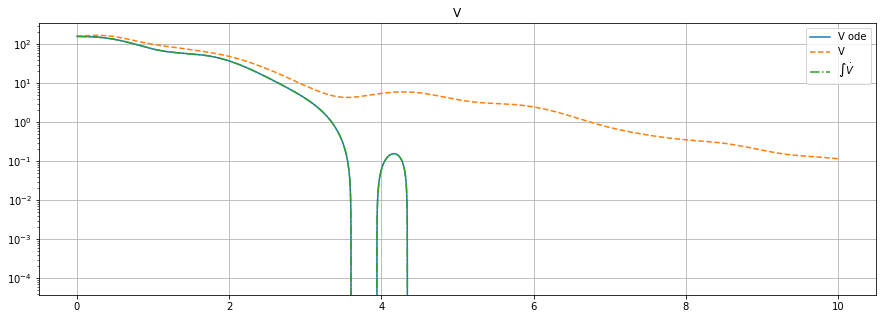

In [36]:
V = V.reshape(-1)
V_ = V_.reshape(-1)
dV_ = dV_.reshape(-1)

dV_int = cumtrapz(dV_,t,axis=0,initial=0)
dV_ = dV_int.reshape(-1)


figure(figsize=(15,5))
title('V')
plot(t, V  + V_[0])
plot(t, V_ - V_[0] + V[0] + V_[0],'--')
# plot(t, dV_.ravel())

plot(t, dV_int - dV_int[0] + V[0] + V_[0],'-.')
yscale('log')
# ylim(bottom=tolerance)
grid(True)
legend(['V ode','V','$\int \dot V$'])

print(amax(abs(V-V_-V[0]+V_[0])))
print(amax(abs(V-dV_int-V[0]+dV_int[0])))
print(amax(abs(V_-dV_int-V_[0]+dV_int[0])))

## Plots

Text(0.5, 1.0, 'q error (deg)')

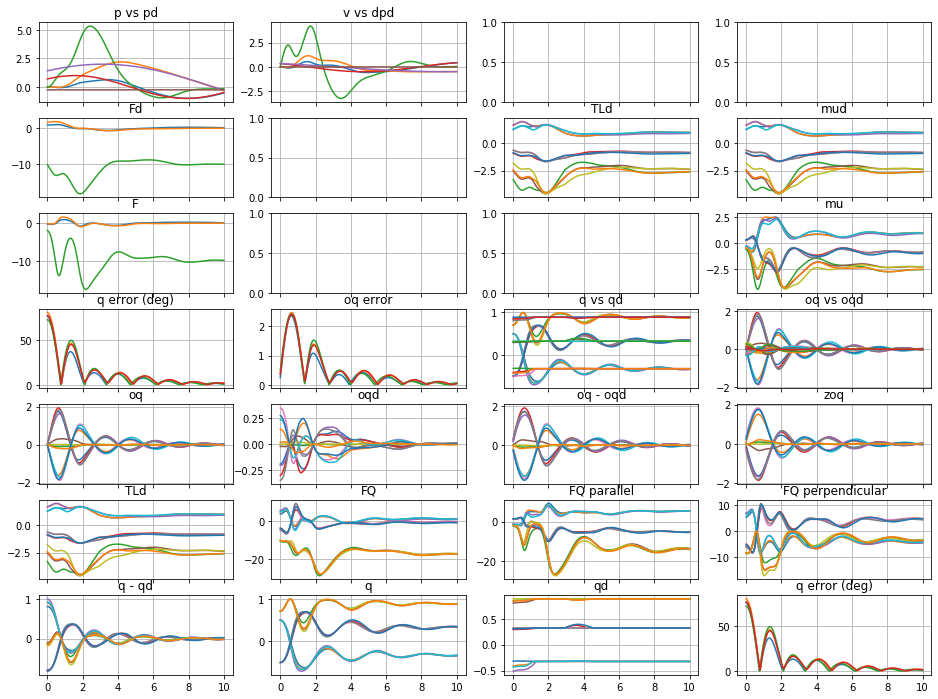

In [37]:
fig, axes = subplots(7, 4, figsize=(16, 12), sharex=True)

all_axes = [ax.grid() for sublist in axes for ax in sublist]

axes[0,0].plot(t,squeeze(p),
        t,squeeze(pd))
axes[0,0].set_title('p vs pd')

axes[0,1].plot(t,squeeze(v),
        t,squeeze(dpd))
axes[0,1].set_title('v vs dpd')

# axes[0,2].plot(t,squeeze(R.reshape(-1,9)),
#         t,squeeze(Rd.reshape(-1,9)))
# axes[0,2].set_title('R vs Rd')

# axes[0,3].plot(t,squeeze(o),
#         t,squeeze(od))
# axes[0,3].set_title('o vs od')

###################################

axes[1,0].plot(t, squeeze(Fd))
axes[1,0].set_title('Fd')

# axes[1,1].plot(t, squeeze(Md))
# axes[1,1].set_title('Md')

axes[1,2].plot(t, squeeze(TLd.reshape(-1,n_cables*n_dims)))
axes[1,2].set_title('TLd')

axes[1,3].plot(t, squeeze(mud.reshape(-1,n_cables*n_dims)))
axes[1,3].set_title('mud')

# ###################################

axes[2,0].plot(t, squeeze(F))
axes[2,0].set_title('F')

# axes[2,1].plot(t, squeeze(M))
# axes[2,1].set_title('M')

# axes[2,2].plot(t, squeeze(TL))
# axes[2,2].set_title('TL')

axes[2,3].plot(t, squeeze(mu.reshape(-1,n_cables*n_dims)))
axes[2,3].set_title('mu')

# ###################################

axes[3,0].plot(t,squeeze(180/pi * arccos(mt(q) @ qd)))
axes[3,0].set_title('q error (deg)')

axes[3,1].plot(t,squeeze(norm(oq-oqd,axis=-2)))
axes[3,1].set_title('oq error')

axes[3,2].plot(t,squeeze(q.reshape(-1,n_cables*n_dims)),t,squeeze(qd.reshape(-1,n_cables*n_dims)))
axes[3,2].set_title('q vs qd')

axes[3,3].plot(t,squeeze(oq.reshape(-1,n_cables*n_dims)), t, squeeze(oqd.reshape(-1,n_cables*n_dims)))
axes[3,3].set_title('oq vs oqd')

# ###############################

axes[4,0].plot(t,squeeze(oq.reshape(-1,n_cables*n_dims)))
axes[4,0].set_title('oq')

axes[4,1].plot(t,squeeze(oqd.reshape(-1,n_cables*n_dims)))
axes[4,1].set_title('oqd')

axes[4,2].plot(t,squeeze((oq - oqd).reshape(-1,n_cables*n_dims)))
axes[4,2].set_title('oq - oqd')

axes[4,3].plot(t,squeeze(zoq.reshape(-1,n_cables*n_dims)))
axes[4,3].set_title('zoq')

# ###############################

axes[5,0].plot(t,squeeze(TLd.reshape(-1,n_cables*n_dims)))
axes[5,0].set_title('TLd')

axes[5,1].plot(t,squeeze(u.reshape(-1,n_cables*n_dims)))
axes[5,1].set_title('FQ')

axes[5,2].plot(t,squeeze(u_parallel).reshape(-1,n_cables*n_dims))
axes[5,2].set_title('FQ parallel')

axes[5,3].plot(t,squeeze(u_perp).reshape(-1,n_cables*n_dims))
axes[5,3].set_title('FQ perpendicular')

# ###############################

axes[6,0].plot(t,squeeze(q.reshape(-1,n_cables*n_dims) - qd.reshape(-1,n_cables*n_dims)))
axes[6,0].set_title('q - qd')

axes[6,1].plot(t,squeeze(q.reshape(-1,n_cables*n_dims)))
axes[6,1].set_title('q')

axes[6,2].plot(t,squeeze(qd.reshape(-1,n_cables*n_dims)))
axes[6,2].set_title('qd')

axes[6,3].plot(t,squeeze(180/pi * arccos(mt(q) @ qd)))
axes[6,3].set_title('q error (deg)')

In [38]:
# abc

### Rebuild auxiliar variables from the integration results

In [39]:
t_step = 1e-1

# Retrieve results at timepoints 't'
t = arange(t0,tf,t_step)
# (p,v,R,o,delta_TLd,q,oq,qR,qo,V) = unpack_solution(sol.sol(t).T)
_, state = process_state(t,sol.sol(t).T)

# Batch compute state variables and actuations

# Fills current namespace with variables from 'state' namespace
for key,val in state.__dict__.items(): 
    exec(key + '=val')

qp = p - q*lq
qv = v - dq*lq

### Graphics definitions

In [40]:
load = array([ [ length/2,  width/2, height/2],
                [-length/2,  width/2, height/2],
                [-length/2, -width/2, height/2],
                [ length/2, -width/2, height/2],
                [ length/2,  width/2, -height/2],
                [-length/2,  width/2, -height/2],
                [-length/2, -width/2, -height/2],
                [ length/2, -width/2, -height/2]] ).T

def load_edges_at_pose(p=array([0,0,0]), R=eye(3)):
    # https://stackoverflow.com/questions/44881885/python-draw-3d-cube/49766400#49766400

    p = p.ravel()
    
    cube_definition = [
        p + R @ load[:,0], 
        p + R @ load[:,1], 
        p + R @ load[:,3], 
        p + R @ load[:,4]
    ]

    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    
    return edges


def quadrotor_edges_at_pose(p=array([0,0,0]), R=eye(3)):

    p = p.ravel()
    
    length = 0.2
    width = 0.2
    height = 0.05

    quad = array([ [ length/2,  width/2, height/2],
                    [-length/2,  width/2, height/2],
                    [-length/2, -width/2, height/2],
                    [ length/2, -width/2, height/2],
                    [ length/2,  width/2, -height/2],
                    [-length/2,  width/2, -height/2],
                    [-length/2, -width/2, -height/2],
                    [ length/2, -width/2, -height/2]] ).T    

    # https://stackoverflow.com/questions/44881885/python-draw-3d-cube/49766400#49766400

    cube_definition = [
        p + R @ quad[:,0], 
        p + R @ quad[:,1], 
        p + R @ quad[:,3], 
        p + R @ quad[:,4]
    ]

    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    
    return edges


def draw_load(ax,p=zeros(3),R=eye(3)):
    
    p = p.reshape(3,1)
    R = R.reshape(3,3)
    
    edges = load_edges_at_pose(p, R)
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k')

    # # Color all faces alike
    # colors = (0,0,1,0.2)

    # Color front face differently
    colors = len(edges)*[(0,0,1,0.2)]
    colors[3] = (1,1,1,0.6)
    
    faces.set_facecolor(colors)
    
    ax.add_collection3d(faces)

    
def draw_ghost_load(ax,p=zeros(3),R=eye(3)):
    
    p = p.reshape(3,1)
    R = R.reshape(3,3)
    
    edges = load_edges_at_pose(p, R)
    faces = Poly3DCollection(edges, linewidths=0.25, edgecolors='k')
    faces.set_facecolor((0,0,1,0.05))
    ax.add_collection3d(faces)

    
    
def draw_q(ax, q, p=zeros([3,1]), R=eye(3), color=(0,1,1)):
    
    # Attachement points for the cables
    rho_inertial = R @ rho + p
    
    # Compute cable position based on direction by TL 
    q = q / norm(q,axis=-2)[..., np.newaxis,:]
    
    # Draw on 'ax'
    ax.quiver(array(rho_inertial[:,0]).astype(float), 
              array(rho_inertial[:,1]).astype(float), 
              array(rho_inertial[:,2]).astype(float), 
              array(-(q*lq)[:,0]).astype(float), 
              array(-(q*lq)[:,1]).astype(float), 
              array(-(q*lq)[:,2]).astype(float),
              color=color,
              arrow_length_ratio=0,
              )
    
def draw_TL(ax, B_TL, p=zeros([3,1]), R=eye(3), color=(0,1,1)):
    
    # Attachement points for the cables
    rho_inertial = R @ rho + p
    
    # Compute cable position based on direction by TL 
    q = R @ ( - B_TL / norm(B_TL,axis=-2)[..., np.newaxis,:])
    
    # Draw on 'ax'
    ax.quiver(array(rho_inertial[:,0]).astype(float), 
              array(rho_inertial[:,1]).astype(float), 
              array(rho_inertial[:,2]).astype(float), 
              array(-(q*lq)[:,0]).astype(float), 
              array(-(q*lq)[:,1]).astype(float), 
              array(-(q*lq)[:,2]).astype(float),
              color=color,
              arrow_length_ratio=0,
              )
    
    
def draw_quadrotor(ax,p=zeros([3,1]),R=eye(3), T=0, color=(0,1,1), alpha = 0.5):
    
    p = p.reshape(3,1)
    R = R.reshape(3,3)
    
    c = hstack([color, alpha])
    
    edges = quadrotor_edges_at_pose(p, R)
    faces = Poly3DCollection(edges, linewidths=0.5, edgecolors='k')
    faces.set_facecolor(c)
    ax.add_collection3d(faces)
    
    # TODO: Move to "draw quadrotor"
    r3 = R @ e3
    ax.quiver3D(array(p[0]).astype(float), 
              array(p[1]).astype(float), 
              array(p[2]).astype(float), 
              array(-T*r3[0]).astype(float), 
              array(-T*r3[1]).astype(float), 
              array(-T*r3[2]).astype(float),
              color=color,
              arrow_length_ratio=0,
              length=0.05
              )


def draw_quadrotors_TL(ax, TL_matrix, p=zeros([3,1]), R=eye(3), color=(0,1,1), alpha=0.5):

    c = hstack([color, alpha])
    
    rho_inertial = R @ rho + p
    
    cable_matrix = R @ (-TL_matrix / norm(TL_matrix,axis=-2)[..., np.newaxis,:]) * lq

    p_quads = rho_inertial - cable_matrix
    
    # Gravity has same shape as TL_matrix
    s = asarray(TL_matrix.shape)
    s[-2] = 1
    
    gravity = g*tile(e3,s)
    
    I_T = (R @ TL_matrix - mQ*gravity)
    
    qT = norm(I_T,axis=-2, keepdims=True)
    
    e1_tile = tile(e1,qT.shape)
    
    r3 = -I_T
    r2 = cross(r3,e1_tile,axis=-2)
    r1 = cross(r2,r3,axis=-2)
    
    Rq = concatenate([r1,r2,r3],axis=-1)
    Rq = Rq / norm(Rq,axis=-2,keepdims=True)
    
    for i in range(p_quads.shape[0]):
        draw_quadrotor(ax, p_quads[i], Rq[i], T=qT[i], color=color)

    return




def draw_quadrotors(ax, qp, qR, qT, color=(0,1,1), alpha=0.5):

    for i in range(len(qp)):        
        draw_quadrotor(ax, qp[i], qR[i], qT[i], color=color)
    
    return

In [41]:
(TLd_min, TLd_opt) = compute_TL(t,Fd)

In [42]:
import ipywidgets as widgets
from ipywidgets import interact

colors = [ array([1,0,0]),
        array([0,1,0]),
        array([0,0,1]),
        array([1,1,0]),
        array([1,0,1]),
        array([0,1,1]),
        array([1,1,1]),
        ]

def f(t_frame,el,az):

    ## New figure
    
    # fig = figure(figsize=(30, 30))

    fig, axs = subplots(1,2,subplot_kw=dict(projection='3d'),figsize=(20, 10))
    fig.subplots_adjust(wspace=-0.1)
    
    # Recover index (of differential eq. solution) for the current time
    i = argmax(t>=t_frame)
    ti = t[i]
    
    Ri = eye(3)
    
    fig.suptitle(f't = {ti:0.2}', fontsize=24)
    
    # TL matrix for the minimal solution
    TL_min_matrix = TLd_min[i]
    
    # TL matrix for the solution with repulsion
    TL_complete_matrix = (TLd_min[i] + delta_TLd[i])
    
    # TL matrix for the optimization solution
    TL_opt_matrix = TLd_opt[i]
        
    ### First subfigure - Inertial view
    
    ax = axs[0]
    
    ax.set_title("Inertial view")
    
    # Minimal solution
    
    draw_TL(ax, TL_min_matrix, p[i], Ri, color=colors[0])
    draw_quadrotors_TL(ax, TL_min_matrix, p[i], Ri, color=colors[0])

    # Repulsion solution
    
    draw_TL(ax, TL_complete_matrix, p[i], Ri, color=colors[1])
    draw_quadrotors_TL(ax, TL_complete_matrix, p[i], Ri, color=colors[1])
  
    # Optimization solution
    
    draw_TL(ax, TL_opt_matrix, p[i], Ri, color=colors[2])
    draw_quadrotors_TL(ax, TL_opt_matrix, p[i], Ri, color=colors[2])

    draw_load(ax, p[i], Ri)
    
    draw_ghost_load(ax, pr(ti), eye(3))
    
    draw_q(ax, q[i], p[i], R=Ri, color=colors[4])
    draw_quadrotors(ax, qp[i], qR[i], qT[i], color=colors[4])
    
    ax.plot(pr(t)[:,0,0].ravel(),
            pr(t)[:,0,1].ravel(),
            pr(t)[:,0,2].ravel())
    
#     ax.auto_scale_xyz(3,3,1)
#     ax.autoscale_view()
    
    ax.view_init(elev=el, azim=az)
    
    ax.set_xlim3d(-2,2)
    ax.set_ylim3d(-2,2)
    ax.set_zlim3d(-2,2)
    
#     ax.axis('equal')
#     ax.axis('scaled') 
#     ax.set_aspect('equal')

    ax.invert_zaxis()
    
#     ### Second subfigure - Body view
    
    ax = axs[1]
    
    ax.set_title("'Same yaw' view")
    
    v = rotationMatrixToEulerAngles(Ri.reshape(3,3))
    v[2] = 0
    Ri = eulerAnglesToRotationMatrix(v).reshape(1,3,3)
    
    draw_TL(ax, TL_min_matrix, R=Ri, color=colors[0])
    draw_quadrotors_TL(ax, TL_min_matrix, R=Ri, color=colors[0])

    # Repulsion solution
    
    draw_TL(ax, TL_complete_matrix, R=Ri, color=colors[1])
    draw_quadrotors_TL(ax, TL_complete_matrix, R=Ri, color=colors[1])
  
    # Optimization solution
    
    draw_TL(ax, TL_opt_matrix, R=Ri, color=colors[2])
    draw_quadrotors_TL(ax, TL_opt_matrix, R=Ri, color=colors[2])

    draw_load(ax, R=Ri)
    
    draw_q(ax, q[i], R=Ri, color=colors[4])
    draw_quadrotors(ax, (qp[i] - p[i]), qR[i], qT[i], color=colors[4])
    
    ax.set_xlim3d(-1,1)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-1.5, 0.5)
    
    ax.view_init(elev=el, azim=az+180)

#     ax.set_aspect('equal')
    
    ax.invert_zaxis()
    
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt

    plt.legend(handles=[mpatches.Patch(color=colors[0], label='TLd min'), 
                       mpatches.Patch(color=colors[1], label='TLd min + delta_TLd'),
                       mpatches.Patch(color=colors[2], label='TLd opt'),
                       mpatches.Patch(color=colors[4], label='TLd actual')])
    
    
    return

a = interact(f, 
         t_frame=widgets.FloatSlider(min=0,max=tf-0.01,value=0,step=0.01),
             el=widgets.FloatSlider(min=0,max=90,value=20),
             az=widgets.FloatSlider(min=0,max=360,value=20),
         continuous_update=False)

interactive(children=(FloatSlider(value=0.0, description='t_frame', max=9.99, step=0.01), FloatSlider(value=20…

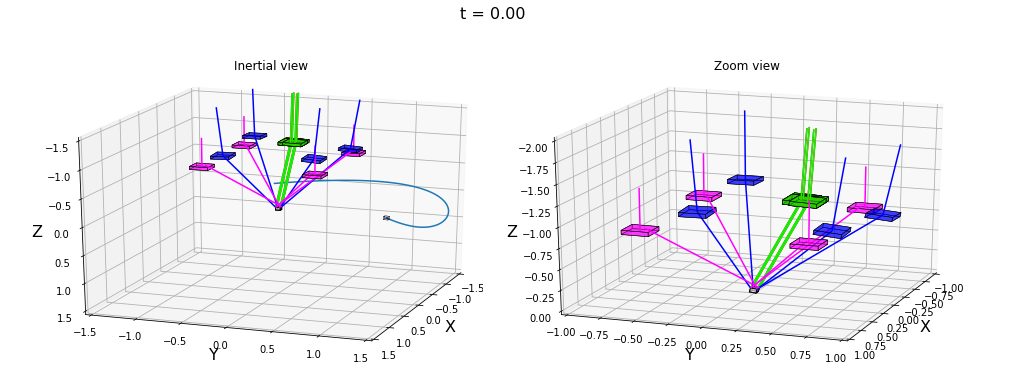

In [43]:
from IPython.display import HTML

fig, axs = subplots(1,2,subplot_kw=dict(projection='3d'),figsize=(18, 6))
fig.subplots_adjust(wspace=-0.1)


el = 20
az = 20

def update_frame(i):
            
    axs[0].clear()
    axs[1].clear()
    
    ax = axs[0]

#     ax.set_xlim3d(-15,15)
#     ax.set_ylim3d(-15,15)
#     ax.set_zlim3d(-10,20)
    
    ax.set_xlim3d(-1.5,1.5)
    ax.set_ylim3d(-1.5,1.5)
    ax.set_zlim3d(-1.5,1.5)

    ax.view_init(elev=el, azim=az)
#     ax.set_aspect('equal')
    ax.invert_zaxis()
    
    ax.set_xlabel('X', size=16)
    ax.set_ylabel('Y', size=16)
    ax.set_zlabel('Z', size=16)

    ax = axs[1]
    
    ax.set_xlim3d(-1.0,1.0)
    ax.set_ylim3d(-1.0,1.0)
    ax.set_zlim3d(-2, 0)

    ax.view_init(elev=el, azim=az)
#     ax.set_aspect('equal')
    ax.invert_zaxis()
    
    ax.set_xlabel('X', size=16)
    ax.set_ylabel('Y', size=16)
    ax.set_zlabel('Z', size=16)
    
    
    ti = t[i]
    
    fig.suptitle(f't = {ti:.2f}', fontsize=16)
    
    Ri = eye(3)
    
    # TLd matrix for the minimal solution
    TLd_min_matrix = TLd_min[i]
    
    # TL matrix for the solution with repulsion
    TLd_complete_matrix = (TLd_min[i] + delta_TLd[i])
    
    # TL matrix for the optimization solution - body
    TLd_opt_matrix = TLd_opt[i]
    
    ### First subfigure - Inertial view
    
    ax = axs[0]
    
    ax.set_title("Inertial view")
    
    # Minimal solution
    
    draw_TL(ax, TLd_min_matrix, p[i], Ri, color=colors[0])
    draw_quadrotors_TL(ax, TLd_min_matrix, p[i], Ri, color=colors[0])

    # Repulsion solution
    
    draw_TL(ax, TLd_complete_matrix, p[i], Ri, color=colors[1])
    draw_quadrotors_TL(ax, TLd_complete_matrix, p[i], Ri, color=colors[1])
  
    # Optimization solution
    
    draw_TL(ax, TLd_opt_matrix, p[i], Ri, color=colors[2])
    draw_quadrotors_TL(ax, TLd_opt_matrix, p[i], Ri, color=colors[2])

    draw_load(ax, p[i], Ri)
    
    draw_ghost_load(ax, pr(ti), eye(3))
    
    draw_q(ax, q[i], p[i], Ri, color=colors[4])
    
    draw_quadrotors(ax, qp[i], qR[i], qT[i],color=colors[4])
    
    ax.plot(pr(t)[:,0,0].ravel(),
            pr(t)[:,0,1].ravel(),
            pr(t)[:,0,2].ravel())
    
    ### Second subfigure - Zoom view
    
    ax = axs[1]
    
    ax.set_title("Zoom view")
    
    draw_TL(ax, TLd_min_matrix, R=R[i], color=colors[0])
    draw_quadrotors_TL(ax, TLd_min_matrix, R=R[i], color=colors[0])

    # Repulsion solution
    
    draw_TL(ax, TLd_complete_matrix, R=R[i], color=colors[1])
    draw_quadrotors_TL(ax, TLd_complete_matrix, R=R[i], color=colors[1])
  
    # Optimization solution - body
    
    draw_TL(ax, TLd_opt_matrix, R=R[i], color=colors[2])
    draw_quadrotors_TL(ax, TLd_opt_matrix, R=R[i], color=colors[2])

    # Draw simulated quadrotors
    draw_q(ax, q[i], R=R[i], color=colors[4])
    draw_quadrotors(ax, qp[i] - p[i], qR[i], qT[i], color=colors[4])

    draw_load(ax, R=R[i])
    
    return

anim = FuncAnimation(fig, update_frame,
                               frames=len(t), interval=1000*t_step, 
                               blit=False)

In [44]:
# HTML(anim.to_html5_video())
# HTML(anim.to_jshtml())